In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sys import float_info # Threshold smallest positive floating value
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd

import torch
import torch.nn as nn

In [2]:
# Generate Data Function - Returns N x 3 and labels
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels

In [29]:
# Set Gaussian Data Params
# Generate Data
N = 500
n = 3 # dimensionality of input random vectors
C = 4 # number of classes
gmm_pdf = {}
gmm_pdf['priors'] = np.array([1/C, 1/C, 1/C, 1/C])
gmm_pdf['m'] = np.array([1*np.ones(n), 4*np.ones(n), 6*np.ones(n), 9*np.ones(n)])
gmm_pdf['C'] = np.array([2*np.eye(n), 2*np.eye(n), 2*np.eye(n), 2*np.eye(n)])




In [5]:
# TwoLayerMLP class
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class TwoLayerMLP(nn.Module):
    # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
    # the output when validating, on top of calculating the negative-log-likelihood using 
    # nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
    
    def __init__(self, d_in, d_hidden, C):
        super(TwoLayerMLP, self).__init__()
        
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_hidden, C)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)  # fc to perceptrons
        x = self.relu(x) # or self.softplus(x) for smooth-ReLU, empirically worse than ReLU
        x = self.fc2(x)  # connect to output layer
        x = self.log_softmax(x)  # for outputs that sum to 1
        return x

In [6]:
# Train Model Function
def train_model(model, data, labels, criterion, optimizer, num_epochs=25):
    # Set up training data
    X_train = torch.FloatTensor(data)
    y_train = torch.LongTensor(labels)

    # Optimize the neural network
    for epoch in range(num_epochs):
        # Set grads to zero explicitly before backprop
        optimizer.zero_grad()
        outputs = model(X_train)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, y_train)
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()

    return model

In [7]:
def model_predict(model, data):
    # Set up test data as tensor
    X_test = torch.FloatTensor(data)

    # Evaluate nn on test data and compare to true labels
    predicted_labels = model(X_test)
    # Back to numpy
    predicted_labels = predicted_labels.detach().numpy()
    
    return np.argmax(predicted_labels, 1)

In [9]:
# MLE Solution
# Analytical optimal solution, aka the normal equation for least squares
# Fit order d polynomial usins training data set with MLE method which
# reduces to least-squares curve fitting here due to additive Gaussian noise
def mle_solution(X, y):
    # Model: y = phi(X)^T*theta
    # LS estimate: theta^* = (phi(X)^T*phi(X))^-1 * phi(X)^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [10]:
def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Loss function is MSE
    return np.mean(error ** 2)

In [18]:
def model_order_selection(X_train, y_train, folds, poly_deg):

  C = len(np.unique(y_train))

  cv = KFold(n_splits=folds, shuffle=True)

  # Polynomial degrees ("hyperparameters") to evaluate 
  degs = np.arange(1, poly_deg, 1)
  n_degs = np.max(degs)

  # scores = cross_val_score(estimator=trained_model, X=X_train, y=y_train, cv=cv, scoring='accuracy')
  mse_valid_mk = np.empty((n_degs, folds)) 
  mse_train_mk = np.empty((n_degs, folds)) # Indexed by model m, data partition k
  truelist=np.empty((n_degs,folds))
  all_models = []

  # 
  for deg in degs:
    k = 0

    # split training set for 10-fold cross validation
    # for each of the 10 smaller sets, train model for 1-10 perceptrons
    for fold, (train_indices, valid_indices) in enumerate(cv.split(X_train)):
      # Extract the training and validation sets from the K-fold split
      X_train_k = X_train[train_indices]
      y_train_k = y_train[train_indices]
      X_valid_k = X_train[valid_indices]
      y_valid_k = y_train[valid_indices]

      model = TwoLayerMLP(X_train.shape[1], deg, C)      
      
      optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
      criterion = nn.CrossEntropyLoss()
      trained_model = train_model(model, X_train_k, y_train_k, criterion, optimizer, num_epochs=100)
      all_models.append(trained_model)

      y_train_pred = model_predict(trained_model,X_train_k)
      y_valid_pred = model_predict(trained_model,X_valid_k)

      truehit = len(np.argwhere(y_valid_pred == y_valid_k))
      truelist[deg-1,k] = truehit/len(y_valid_k)

      # Record MSE as well for this model and k-fold
      mse_train_mk[deg - 1, k] = mse(y_train_pred, y_train_k)
      mse_valid_mk[deg - 1, k] = mse(y_valid_pred, y_valid_k)
      k += 1

      # # Saving the model
      # save_path = f'./model-fold-{fold}.pth'
      # torch.save(model.state_dict(), save_path)
    # print("hit rate: ", truelist)
    #print("Num Perceptrons = ",deg, " Hit Rate: ", np.mean(truelist[]))

  hit_rate_train = np.mean(truelist, axis=1)

  # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
  mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
  mse_valid_m = np.mean(mse_valid_mk, axis=1) 


  # +1 as the index starts from 0 while the degrees start from 1
  optimal_d = np.argmin(mse_valid_m) + 1

  optimal_model = all_models[optimal_d-1]
  #print("The model selected to best fit the data without overfitting is: d={}".format(optimal_d))
  optimal_hit = hit_rate_train[optimal_d-1]
  print("Perceptrons: ", optimal_d, "  Hit Rate: ",optimal_hit)

  return optimal_d, mse_valid_m, hit_rate_train, optimal_model

In [36]:
X_test, y_test = generate_data_from_gmm(100000,gmm_pdf)

Perceptrons:  7   Hit Rate:  0.7
3.48759  = MSE
Perceptrons:  8   Hit Rate:  0.645
1.56735  = MSE
Perceptrons:  9   Hit Rate:  0.6419999999999999
1.50323  = MSE
Perceptrons:  10   Hit Rate:  0.699
1.45394  = MSE
Perceptrons:  9   Hit Rate:  0.7170000000000001
1.60141  = MSE
Perceptrons:  10   Hit Rate:  0.7044
1.79611  = MSE


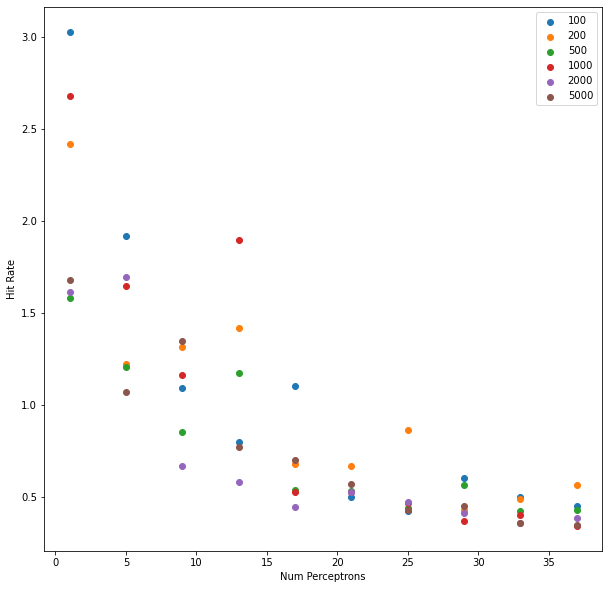

In [40]:
fig_all, ax_all = plt.subplots(figsize=(10, 10))

marker_shapes = 'ox+*.' # Accomodates up to C=5
marker_colors = 'brgmy'
degs = np.arange(1, 40, 4)

N = [100, 200, 500, 1000, 2000, 5000]
for samples in N:
    X_train, y_train = generate_data_from_gmm(samples, gmm_pdf)
    op_d, mse_val_m, hit_rate, opt_model = model_order_selection(X_train, y_train, 10, 11)
    ax_all.scatter(degs,mse_val_m,label=samples)



    # model = TwoLayerMLP(X_train.shape[1], op_d, C)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # criterion = nn.CrossEntropyLoss()
    # trained_model = train_model(model, X_train, y_train, criterion, optimizer, num_epochs=100)
    y_test_pred = model_predict(opt_model,X_test)
    mse_test = mse(y_test_pred, y_test)
    print(mse_test, " = MSE")

    # truehit = len(np.argwhere(y_train_pred == y_train))
    # print(truehit/len(y_train))
    
plt.legend()
plt.xlabel("Num Perceptrons")
plt.ylabel("Hit Rate")
plt.show()
N = 10000
# 

In [ ]:
print(dir(opt_model))

In [14]:
op_d, mse_val_m = model_order_selection(X_train, y_train, 10, 21)

model = TwoLayerMLP(X_train.shape[1], op_d, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trained_model = train_model(model, X_train, y_train, criterion, optimizer, num_epochs=100)


y_train_pred = model_predict(trained_model,X_train)

truehit = len(np.argwhere(y_train_pred == y_train))
print(truehit/len(y_train))


KeyboardInterrupt: 

In [ ]:
# Explore the Model?
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

In [ ]:
 # Set fixed random number seed
torch.manual_seed(42)

K=10
cv = KFold(n_splits=K, shuffle=True)

# Polynomial degrees ("hyperparameters") to evaluate 
degs = np.arange(1, 21, 1)
n_degs = np.max(degs)

# scores = cross_val_score(estimator=trained_model, X=X_train, y=y_train, cv=cv, scoring='accuracy')
mse_valid_mk = np.empty((n_degs, K)) 
mse_train_mk = np.empty((n_degs, K)) # Indexed by model m, data partition k
truelist=np.empty((n_degs,K))
for deg in degs:
  k = 0
  
  # K-fold Cross Validation model evaluation
  # truelist=[]

  
  for fold, (train_indices, valid_indices) in enumerate(cv.split(X_train)):
    # Extract the training and validation sets from the K-fold split
    X_train_k = X_train[train_indices]
    y_train_k = y_train[train_indices]
    X_valid_k = X_train[valid_indices]
    y_valid_k = y_train[valid_indices]

    model = TwoLayerMLP(X_train.shape[1], deg, C)
    model.apply(reset_weights)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    trained_model = train_model(model, X_train_k, y_train_k, criterion, optimizer, num_epochs=100)

    y_train_pred = model_predict(trained_model,X_train_k)
    y_valid_pred = model_predict(trained_model,X_valid_k)

    truehit = len(np.argwhere(y_valid_pred == y_valid_k))
    truelist[deg -1, k] = truehit/len(y_valid_k)

    # Record MSE as well for this model and k-fold
    mse_train_mk[deg - 1, k] = mse(y_train_pred, y_train_k)
    mse_valid_mk[deg - 1, k] = mse(y_valid_pred, y_valid_k)
    k += 1

    # # Saving the model
    # save_path = f'./model-fold-{fold}.pth'
    # torch.save(model.state_dict(), save_path)
  # print("hit rate: ", truelist)
  print("Num Perceptrons = ",deg, " Hit Rate: ", np.mean(truelist[deg-1,:]))

hit_rate_train = np.mean(truelist, axis=1)

# STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
mse_valid_m = np.mean(mse_valid_mk, axis=1) 

plt.figure()
plt.scatter(mse_val_m)
plt.show()

# +1 as the index starts from 0 while the degrees start from 1
optimal_d = np.argmin(mse_valid_m) + 1
print("The model selected to best fit the data without overfitting is: d={}".format(optimal_d))
optimal_hit = hit_rate_train[optimal_d-1]
print("optimal hit at ", optimal_hit)

model = TwoLayerMLP(X_train.shape[1], optimal_d, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trained_model = train_model(model, X_train, y_train, criterion, optimizer, num_epochs=100)

y_train_pred = model_predict(trained_model,X_train)

truehit = len(np.argwhere(y_train_pred == y_train))
print(truehit/len(y_train))


In [ ]:
plt.figure()
plt.scatter(degs,hit_rate_train*100)
plt.xlabel("Num Perceptrons")
plt.ylabel("Hit Rate")
plt.show()

In [ ]:
hit_rate_train = np.mean(truelist, axis=1)
print(hit_rate_train)

In [ ]:
print(trained_model.state_dict())

In [ ]:
 # Set fixed random number seed
torch.manual_seed(42)
model = TwoLayerMLP(X_train.shape[1], optimal_d, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trained_model = train_model(model, X_train, y_train, criterion, optimizer, num_epochs=100)

y_train_pred = model_predict(trained_model,X_train)

truehit = len(np.argwhere(y_train_pred == y_train))
print(truehit/len(y_train))

In [ ]:
# Plot MSE vs degree
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(degs, mse_train_m, color="b", marker="s", label=r"$D_{train}$")
ax.plot(degs, mse_valid_m, color="r", marker="x", label=r"$D_{valid}$")

# Use logarithmic y-scale as MSE values get very large
ax.set_yscale('log')
# Force x-axis for degrees to be integer
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend(loc='upper left', shadow=True)
plt.xlabel("Model Polynomial Order")
plt.ylabel("MSE")
plt.title("MSE estimates with {}-fold cross-validation".format(K))
plt.show()

In [ ]:
loss_function = nn.CrossEntropyLoss()

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)
num_folds = 10

cv = KFold(n_splits=num_folds, random_state=1, shuffle=True)

# K-fold Cross Validation model evaluation
for fold in np.arange(1, num_folds+1):

    # Set up training data
    X_train = torch.FloatTensor(X)
    y_train = torch.LongTensor(labels)

    model = TwoLayerMLP(X.shape[1], 16, C)
    model.apply(reset_weights)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Optimize the neural network
    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set grads to zero explicitly before backprop
        optimizer.zero_grad()
        outputs = model(X_train)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, y_train)
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0


scores = cross_val_score(model, X, labels, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))


model = train_model(model, X, labels, criterion, optimizer, num_epochs=100)